# Preprocessing

In this lab, we will be exploring how to preprocess tweets for sentiment analysis. We will provide a function for preprocessing tweets during this week's assignment, but it is still good to know what is going on under the hood. By the end of this lecture, you will see how to use the [NLTK](http://www.nltk.org) package to perform a preprocessing pipeline for Twitter datasets.

## Setup

You will be doing sentiment analysis on tweets in the first two weeks of this course. To help with that, we will be using the [Natural Language Toolkit (NLTK)](http://www.nltk.org/howto/twitter.html) package, an open-source Python library for natural language processing. It has modules for collecting, handling, and processing Twitter data, and you will be acquainted with them as we move along the course.

For this exercise, we will use a Twitter dataset that comes with NLTK. This dataset has been manually annotated and serves to establish baselines for models quickly. Let us import them now as well as a few other libraries we will be using.

In [3]:
import nltk                                # Python library for NLP
from nltk.corpus import twitter_samples    # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt            # library for visualization
import random                              # pseudo-random number generator

## About the Twitter dataset

The sample dataset from NLTK is separated into positive and negative tweets. It contains 5000 positive tweets and 5000 negative tweets exactly. The exact match between these classes is not a coincidence. The intention is to have a balanced dataset. That does not reflect the real distributions of positive and negative classes in live Twitter streams. It is just because balanced datasets simplify the design of most computational methods that are required for sentiment analysis. However, it is better to be aware that this balance of classes is artificial. 

The dataset is already downloaded in the Coursera workspace. In a local computer however, you can download the data by doing:

In [ ]:
# downloads sample twitter dataset. uncomment the line below if running on a local machine.
# nltk.download('twitter_samples')

We can load the text fields of the positive and negative tweets by using the module's `strings()` method like this:

In [4]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

Next, we'll print a report with the number of positive and negative tweets. It is also essential to know the data structure of the datasets

In [5]:
print('Number of positive tweets: ', len(all_positive_tweets))
print('Number of negative tweets: ', len(all_negative_tweets))

print('\nThe type of all_positive_tweets is: ', type(all_positive_tweets))
print('The type of a tweet entry is: ', type(all_negative_tweets[0]))

for pos_tweet in all_positive_tweets[1:5]:
    print (pos_tweet)


for neg_tweet in all_negative_tweets[1:5]:
    print (neg_tweet)

Number of positive tweets:  5000
Number of negative tweets:  5000

The type of all_positive_tweets is:  <class 'list'>
The type of a tweet entry is:  <class 'str'>
@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
@97sides CONGRATS :)
yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days
Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(
@Hegelbon That heart sliding into the waste basket. :(
“@ketchBurning: I hate Japanese call him "bani" :( :(”

Me too
Dang starting next week I have "work" :(


We can see that the data is stored in a list and as you might expect, individual tweets are stored as strings.

You can make a more visually appealing report by using Matplotlib's [pyplot](https://matplotlib.org/tutorials/introductory/pyplot.html) library. Let us see how to create a [pie chart](https://matplotlib.org/3.2.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py) to show the same information as above. This simple snippet will serve you in future visualizations of this kind of data.

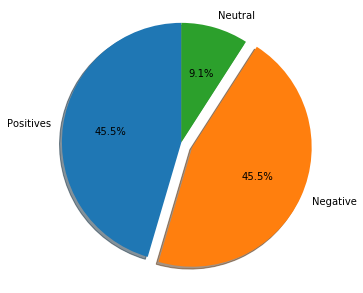

In [10]:
# Declare a figure with a custom size
fig = plt.figure(figsize=(5, 5))

# labels for the two classes
labels = 'Positives', 'Negative', 'Neutral'

# Sizes for each slide
sizes = [len(all_positive_tweets), len(all_negative_tweets), 1000] 

explode = (0, 0.1, 0)

# Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Display the chart
plt.show()

## Looking at raw texts

Before anything else, we can print a couple of tweets from the dataset to see how they look. Understanding the data is responsible for 80% of the success or failure in data science projects. We can use this time to observe aspects we'd like to consider when preprocessing our data.

Below, you will print one random positive and one random negative tweet. We have added a color mark at the beginning of the string to further distinguish the two. (Warning: This is taken from a public dataset of real tweets and a very small portion has explicit content.)

In [11]:
# print positive in greeen
print('\033[92m' + all_positive_tweets[random.randint(0,5000)])

# print negative in red
print('\033[91m' + all_negative_tweets[random.randint(0,5000)])

Gamer Follow Train!
Follow Me
Retweet this
Follow all who retweeted
Gain active followers :) 120
all I want is for my icon to be a selfie of Jack and I :((


One observation you may have is the presence of [emoticons](https://en.wikipedia.org/wiki/Emoticon) and URLs in many of the tweets. This info will come in handy in the next steps.

## Preprocess raw text for Sentiment analysis

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

* Tokenizing the string
* Lowercasing
* Removing stop words and punctuation
* Stemming

The videos explained each of these steps and why they are important. Let's see how we can do these to a given tweet. We will choose just one and see how this is transformed by each preprocessing step.

In [13]:
# Our selected sample. Complex enough to exemplify each step
tweet = all_positive_tweets[2277]
print(tweet)

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i


Let's import a few more libraries for this purpose.

In [12]:
# download the stopwords from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

### Remove hyperlinks,  Twitter marks and styles

Since we have a Twitter dataset, we'd like to remove some substrings commonly used on the platform like the hashtag, retweet marks, and hyperlinks. We'll use the [re](https://docs.python.org/3/library/re.html) library to perform regular expression operations on our tweet. We'll define our search pattern and use the `sub()` method to remove matches by substituting with an empty character (i.e. `''`)

In [15]:
print('\033[92m' + tweet)
print('\033[94m')

# remove old style retweet text "RT"
tweet2 = re.sub(r'^RT[\s]+', '', tweet)

# remove hyperlinks
tweet2 = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet2)

# remove hashtags
# only removing the hash # sign from the word
tweet2 = re.sub(r'#', '', tweet2)

print(tweet2)

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i

My beautiful sunflowers on a sunny Friday morning off :) sunflowers favourites happy Friday off… 


### Tokenize the string

To tokenize means to split the strings into individual words without blanks or tabs. In this same step, we will also convert each word in the string to lower case. The [tokenize](https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual) module from NLTK allows us to do these easily:

In [16]:
print()
print('\033[92m' + tweet2)
print('\033[94m')

# instantiate tokenizer class
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# tokenize tweets
tweet_tokens = tokenizer.tokenize(tweet2)

print()
print('Tokenized string:')
print(tweet_tokens)


My beautiful sunflowers on a sunny Friday morning off :) sunflowers favourites happy Friday off… 


Tokenized string:
['my', 'beautiful', 'sunflowers', 'on', 'a', 'sunny', 'friday', 'morning', 'off', ':)', 'sunflowers', 'favourites', 'happy', 'friday', 'off', '…']


### Remove stop words and punctuations

The next step is to remove stop words and punctuation. Stop words are words that don't add significant meaning to the text. You'll see the list provided by NLTK when you run the cells below.

In [17]:
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english') 

print('Stop words\n')
print(stopwords_english)

print('\nPunctuation\n')
print(string.punctuation)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

We can see that the stop words list above contains some words that could be important in some contexts. 
These could be words like _i, not, between, because, won, against_. You might need to customize the stop words list for some applications. For our exercise, we will use the entire list.

For the punctuation, we saw earlier that certain groupings like ':)' and '...'  should be retained when dealing with tweets because they are used to express emotions. In other contexts, like medical analysis, these should also be removed.

Time to clean up our tokenized tweet!

In [19]:
print()
print('\033[92m')
print(tweet_tokens)
print('\033[94m')


tweets_clean = []

for word in tweet_tokens: # Go through every word in your tokens list
    if (word not in stopwords_english and  # remove stopwords
        word not in string.punctuation):  # remove punctuation
        tweets_clean.append(word)

print('removed stop words and punctuation:')
print(tweets_clean)



['my', 'beautiful', 'sunflowers', 'on', 'a', 'sunny', 'friday', 'morning', 'off', ':)', 'sunflowers', 'favourites', 'happy', 'friday', 'off', '…']

removed stop words and punctuation:
['beautiful', 'sunflowers', 'sunny', 'friday', 'morning', ':)', 'sunflowers', 'favourites', 'happy', 'friday', '…']


Please note that the words **happy** and **sunny** in this list are correctly spelled. 

### Stemming

Stemming is the process of converting a word to its most general form, or stem. This helps in reducing the size of our vocabulary.

Consider the words: 
 * **learn**
 * **learn**ing
 * **learn**ed
 * **learn**t
 
All these words are stemmed from its common root **learn**. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, **happi** and **sunni**. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

 * **happ**y
 * **happi**ness
 * **happi**er
 
We can see that the prefix **happi** is more commonly used. We cannot choose **happ** because it is the stem of unrelated words like **happen**.
 
NLTK has different modules for stemming and we will be using the [PorterStemmer](https://www.nltk.org/api/nltk.stem.html#module-nltk.stem.porter) module which uses the [Porter Stemming Algorithm](https://tartarus.org/martin/PorterStemmer/). Let's see how we can use it in the cell below.

In [20]:
print()
print('\033[92m')
print(tweets_clean)
print('\033[94m')

# Instantiate stemming class
stemmer = PorterStemmer() 

# Create an empty list to store the stems
tweets_stem = [] 

for word in tweets_clean:
    stem_word = stemmer.stem(word)  # stemming word
    tweets_stem.append(stem_word)  # append to the list

print('stemmed words:')
print(tweets_stem)



['beautiful', 'sunflowers', 'sunny', 'friday', 'morning', ':)', 'sunflowers', 'favourites', 'happy', 'friday', '…']

stemmed words:
['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


That's it! Now we have a set of words we can feed into to the next stage of our machine learning project.

In [ ]:
## process_tweet()

As shown above, preprocessing consists of multiple steps before you arrive at the final list of words. We will not ask you to replicate these however. In the week's assignment, you will use the function `process_tweet(tweet)` available in _utils.py_. We encourage you to open the file and you'll see that this function's implementation is very similar to the steps above.

To obtain the same result as in the previous code cells, you will only need to call the function `process_tweet()`. Let's do that in the next cell.

In [21]:
from utils import process_tweet # Import the process_tweet function

# choose the same tweet
tweet = all_positive_tweets[2277]

print()
print('\033[92m')
print(tweet)
print('\033[94m')

# call the imported function
tweets_stem = process_tweet(tweet); # Preprocess a given tweet

print('preprocessed tweet:')
print(tweets_stem) # Print the result



My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i

preprocessed tweet:
['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


That's it for this lab! You now know what is going on when you call the preprocessing helper function in this week's assignment. Hopefully, this exercise has also given you some insights on how to tweak this for other types of text datasets.